In [14]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import math
import toml
import pykitti

import matplotlib
from matplotlib.animation import FuncAnimation,PillowWriter

In [15]:
param = toml.load("config.toml")
basedir = param.get("basedir")
date = param.get("date")
drive = param.get("drive")

# Load the data. Optionally, specify the frame range to load.
dataset = pykitti.raw(basedir, date, drive)

In [16]:
dataset_gray = list(dataset.gray)
dataset_rgb = list(dataset.rgb)
dataset_velo = list(dataset.velo)
oxts = dataset.oxts

In [17]:
a = 6378137.0
b = 6356752.3142
e = math.sqrt(1-(b**2/a**2))
x_gps = []
y_gps = []
z_gps = []
yaw_list = []
ax_list=[]
ay_list=[]
p = []

#Lat,long,alt -> x,y,z
def gps_raw_to_xyz(lat,long,alt):
    return s*a*(np.pi*long/180) , s*a*np.log(np.tan(np.pi*(90+lat)/360)) , alt 


lat_0 =  oxts[0][0][0]
long_0 = oxts[0][0][1]
alt_0 = oxts[0][0][2]
    
phi = oxts[0][0][3]
theta = oxts[0][0][4]
psi = oxts[0][0][5]
    
s = np.cos(lat_0*np.pi/180)
x_0 =  s*a*(np.pi*long_0/180)
y_0 = s*a*np.log(np.tan(np.pi*(90+lat_0)/360))
z_0 = alt_0
    
Tr_0_inv = np.linalg.inv(np.asarray([[np.cos(theta)*np.cos(psi),np.cos(psi)*np.sin(phi)*np.sin(theta) - np.cos(phi)*np.sin(psi),np.cos(phi)*np.cos(psi)*np.sin(theta) + np.sin(theta)*np.sin(psi),x_0],
                   [np.cos(theta)*np.sin(psi),np.cos(psi)*np.cos(phi) + np.sin(phi)*np.sin(psi)*np.sin(theta),-np.sin(phi)*np.cos(psi) + np.sin(theta)*np.sin(psi)*np.cos(phi),y_0],
                   [-np.sin(theta),np.cos(theta)*np.sin(phi),np.cos(phi)*np.sin(theta),z_0],
                   [0,0,0,1]]))
    
    
for i in range(0,len(oxts)):
    lat = oxts[i][0][0]
    long = oxts[i][0][1]
    alt = oxts[i][0][2]
    yaw = oxts[i][0][5]
    ax = oxts[i][0][11]
    ay = oxts[i][0][12]
    
    
    N = a/math.sqrt(1-e**2 * np.sin(lat))
    x,y,z = gps_raw_to_xyz(lat,long,alt)
    
    p_g = np.asarray([[x],[y],[z],[1]])
    p = np.dot(Tr_0_inv, p_g)
    
    x_gps.append((p[0]))
    y_gps.append((p[1]))
    z_gps.append(p[2])
    yaw_list.append([yaw])
    ax_list.append([ax])
    ay_list.append([ay])

<IPython.core.display.Javascript object>


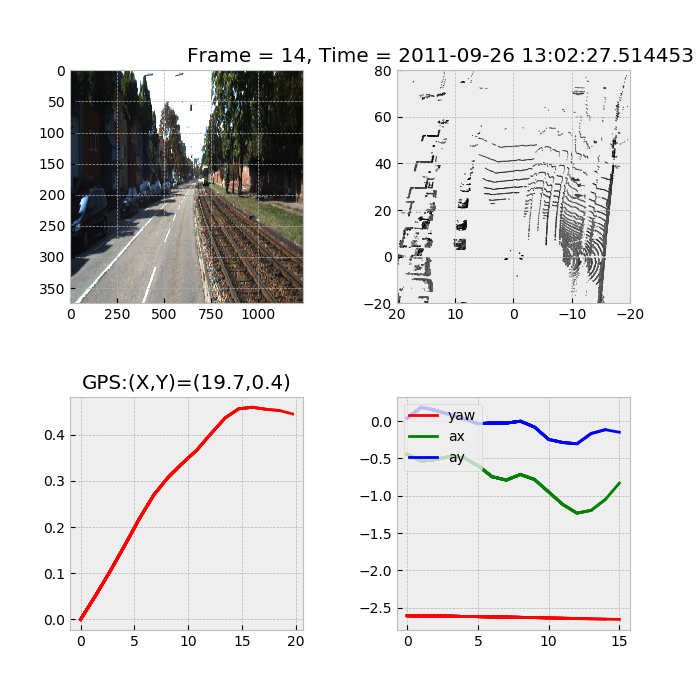

In [18]:
%matplotlib notebook


point_size = 0.01 * (1. / 0.2)
axes_limits = [
    [-20, 80], # X axis range
    [-20, 20], # Y axis range
    [-3, 10]   # Z axis range
]

# create empty lists for the x and y data
my_var = [i for i in range(108)]
x = []
y = []
yaw=[]
ax=[]
ay=[]
t=[]
# create the figure and axes objects
fig, axes = plt.subplots(nrows=2, ncols=2,  figsize=(7,7))
axes[1,1].plot(t, yaw, color="red",label='yaw')
axes[1,1].plot(t, ax, color="green",label='ax')
axes[1,1].plot(t, ay, color="blue",label='ay')
leg = axes[1,1].legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
plt.style.use("bmh")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


def animate(i):
    
    t.append(my_var[i])
    x.append((x_gps[i][0]))
    y.append((y_gps[i][0]))
    #z.append((z_gps[i][0]))
    
    axes[0,0].set_title(u"Frame = {}, Time = {}".format(t[i],dataset.timestamps[i]),horizontalalignment='left')
  

    ##############################################
    
    axes[1,0].set_title(u"GPS:(X,Y)=({:.1f},{:.1f})".format(x_gps[i][0],y_gps[i][0]),horizontalalignment='center')
    axes[1,0].plot(x, y, color="red")
    
    ################################
  
    yaw.append((yaw_list[i][0]))
    ax.append((ax_list[i][0]))
    ay.append((ay_list[i][0]))
    
    axes[1,1].plot(t, yaw, color="red",label='yaw')
    axes[1,1].plot(t, ax, color="green",label='ax')
    axes[1,1].plot(t, ay, color="blue",label='ay')
    
    ####################################
    
    axes[0, 0].imshow(dataset_rgb[i][1],animated=True,aspect='auto')
    
    ####################################
    
    axes[0,1].clear()
    velo_range = range(0, dataset_velo[i].shape[0], 1)
    #velo_frame = dataset_velo[i][velo_range, :] 
    p = [i for i in dataset_velo[i][velo_range,:] if i[2] > -1.5] # Eliminate Ground beams
    p = np.asarray(p)
    axs=[1,0]
    
    axes[0,1].scatter(*np.transpose(p[:, axs]), s=point_size, c=p[:, 3], cmap='gray')
    axes[0,1].set_xlim(axes_limits[axs[0]])
    axes[0,1].set_ylim(axes_limits[axs[1]])  
    axes[0,1].invert_xaxis()
    axes[0,1].plot()  
    
    ###############################

    
ani = FuncAnimation(fig, animate, interval=100, repeat=False,blit=False)

#Uncomment to save as gif
#ani.save("visualizer2.gif", writer=PillowWriter(fps=5))

plt.show()